In [2]:
import logging
import datetime
from conflict_monitoring_ntl.layers import get_rasters_for_admin
from conflict_monitoring_ntl.viz import plot_layer_comparison

import logging
logging.getLogger("urllib3").setLevel(logging.ERROR)


In [3]:
logging.basicConfig(level=logging.ERROR)

In [4]:
%load_ext autoreload
%autoreload 2

Questions:

1. What settlements to take (overview of that)
2. Illustration of noise
3. How to binarize the data (different levels and visualization of that)

Other:

1. What settlements to use (Grid3, GADM)?

## Syria

In [5]:
date = datetime.date(2023, 12, 28)  # used for SDGSat tile

### Hassakeh

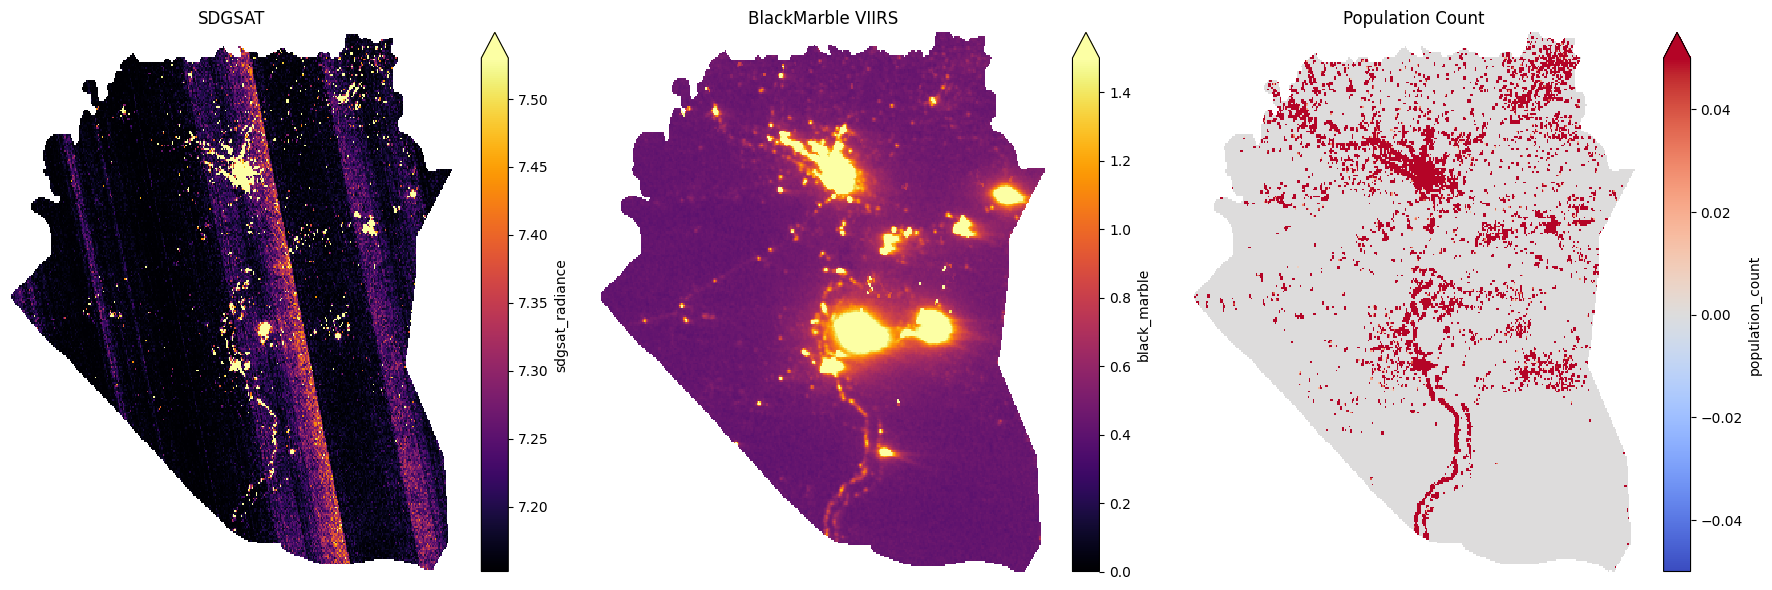

In [6]:
xds = get_rasters_for_admin("Hassakeh", date)
plot_layer_comparison(xds)

In [7]:
xds

<xarray.Dataset> Size: 3MB
Dimensions:           (lat: 307, lon: 334)
Coordinates:
  * lon               (lon) float64 3kB 40.02 40.02 40.03 ... 41.4 41.4 41.41
  * lat               (lat) float64 2kB 36.84 36.84 36.83 ... 35.57 35.57 35.57
    spatial_ref       int64 8B 0
Data variables:
    population_count  (lat, lon) float32 410kB nan nan nan nan ... nan nan nan
    sdgsat_dn         (lat, lon) float64 820kB nan nan nan nan ... nan nan nan
    sdgsat_radiance   (lat, lon) float64 820kB nan nan nan nan ... nan nan nan
    sdgsat_bool       (lat, lon) float64 820kB nan nan nan nan ... nan nan nan
    black_marble      (lat, lon) float32 410kB ...

In [8]:
import hvplot.xarray

In [19]:
from holoviews import opts

def hide_axes(plot, element):
    plot.state.xaxis.visible = False
    plot.state.yaxis.visible = False


sdgsat_plot = xds["sdgsat_radiance"].hvplot.image(
    x="lon", 
    y="lat", 
    geo=True,
    crs=xds.rio.crs,
    cmap='inferno',
    width=400,
    height=400,
    data_aspect=1,
    clim=(7, 8),
    title="SDGSat (resampled)",
    value_label="Radiance (nW/cm²/sr)"
).opts(hooks=[hide_axes])

sdgsat_plot_bool = xds["sdgsat_bool"].hvplot.image(
    x="lon", 
    y="lat", 
    geo=True,
    crs=xds.rio.crs,
    cmap=["black", "white"],
    colorbar=True,
    width=400,
    height=400,
    data_aspect=1,
    clim=(0, 1),
    title="SDGSat (resampled)",
    value_label="Bool"
).opts(hooks=[hide_axes])

bm_plot = xds["black_marble"].hvplot.image(
    x="lon", 
    y="lat", 
    geo=True,
    crs=xds.rio.crs,
    cmap='inferno',
    width=400,
    height=400,
    data_aspect=1,
    clim=(0, 8),
    title="Black Marble"
).opts(hooks=[hide_axes])

ghs_plot = xds["population_count"].hvplot.image(
    x="lon", 
    y="lat", 
    geo=True,
    crs=xds.rio.crs,
    cmap='cividis',
    width=400,
    height=400,
    data_aspect=1,
    clim=(0, 100),
    title="GHSL: Global population surface (2020)"
).opts(hooks=[hide_axes])

layout = sdgsat_plot + sdgsat_plot_bool + bm_plot + ghs_plot
layout.opts(framewise=True).cols(2)

:Layout
   .Image.I   :Image   [lon,lat]   (sdgsat_radiance)
   .Image.II  :Image   [lon,lat]   (sdgsat_bool)
   .Image.III :Image   [lon,lat]   (black_marble)
   .Image.IV  :Image   [lon,lat]   (population_count)

In [32]:
import holoviews as hv

ghs_plot = xds["population_count"].hvplot.image(
    x="lon", 
    y="lat", 
    geo=True,
    crs=xds.rio.crs,
    cmap='cividis',
    width=400,
    height=400,
    data_aspect=1,
    clim=(0, 100),
    tiles='EsriImagery',
    title="GHSL: Global population surface (2020)"
)

ghs_plot

:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [lon,lat]   (population_count)

In [ ]:
import rioxarray
import xarray as xr
filepath = "../data/sdgsat/KX10_GIU_20211110_E121.18_N30.06_202200120796_L4A/KX10_GIU_20211110_E121.18_N30.06_202200120796_L4A_A_LH.tif"
xr_img = rioxarray.open_rasterio(filepath)  # adjust chunk size as needed
xr_img_small = xr_img.coarsen(x=1000, y=1000, boundary='pad').mean()

In [48]:
import rasterio

with rasterio.open(filepath) as src:
    shape = src.shape           # (height, width)
    count = src.count           # Number of bands
    dtype = src.dtypes[0]       # Data type
    crs = src.crs
    transform = src.transform
    # Optionally, get bounds, nodata, etc.

import numpy as np

height, width = shape
bands = count

# For single band
black_array = np.zeros((height, width), dtype=dtype)
da = xr.DataArray(black_array, dims=["y", "x"])

# Assign CRS and transform with rioxarray
da = da.rio.write_crs(crs)
da = da.rio.write_transform(transform)

In [51]:
da

<xarray.DataArray (y: 36736, x: 22625)> Size: 2GB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(36736, 22625), dtype=uint16)
Coordinates:
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x

In [49]:
da.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]')

In [50]:
hvplot_img = da.hvplot.image(
    x='x', 
    y='y',
    geo=True,
    crs=da.rio.crs,
    rasterize=True,
    tiles='OSM',  # Adds interactive background map
    cmap='viridis',  # Choose suitable colormap
    width=600, height=400
)

DataError: xarray Dataset must define coordinates for all defined kdims, [Dimension('x'), Dimension('y')] coordinates not found.

XArrayInterface expects gridded data, for more information on supported datatypes see https://holoviews.org/user_guide/Gridded_Datasets.html

In [37]:
hvplot_img

KeyboardInterrupt: 

### Ras Al Ain

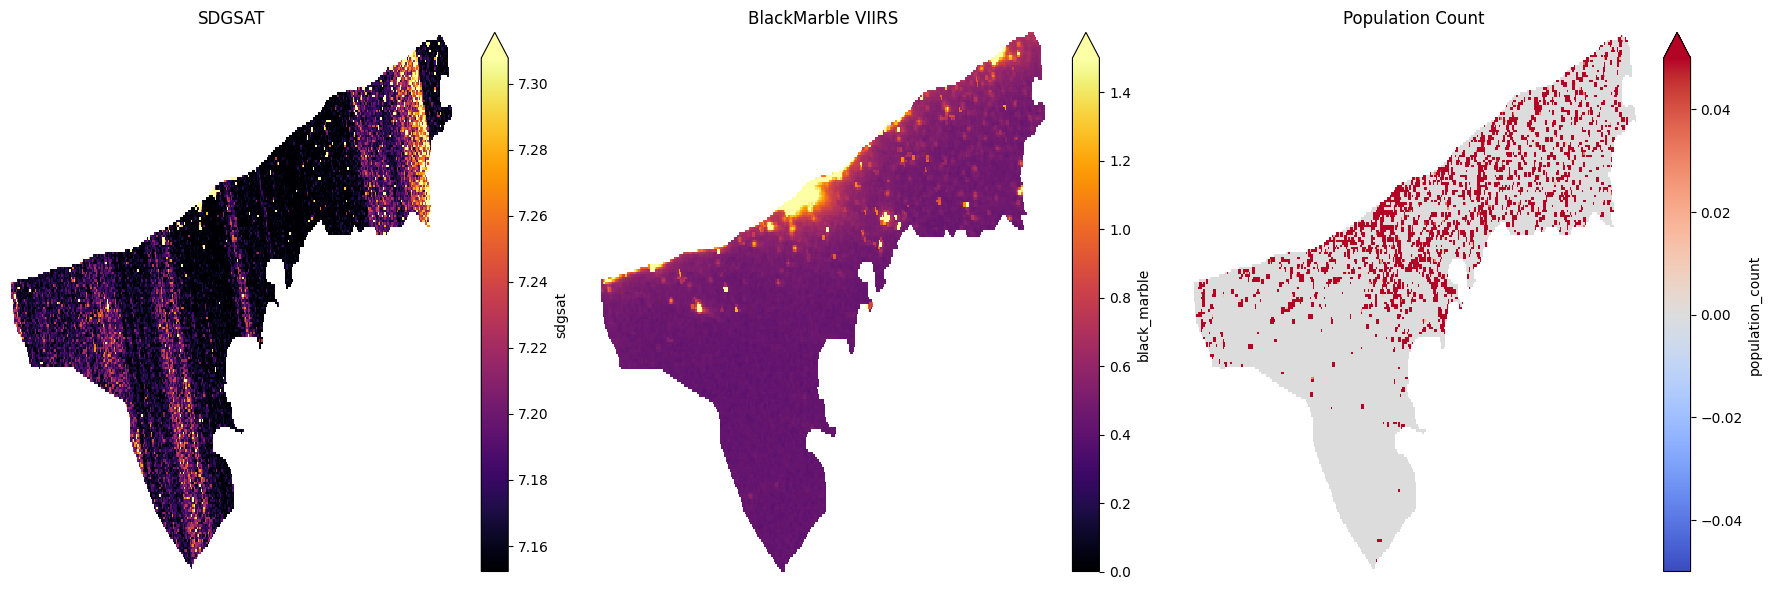

In [6]:
xds = get_rasters_for_admin("Ras_Al_Ain", date)
plot_layer_comparison(xds)

## Mali

In [7]:
date = datetime.date(2024, 1, 30)  # used for SDGSat tile

### Bandiagara

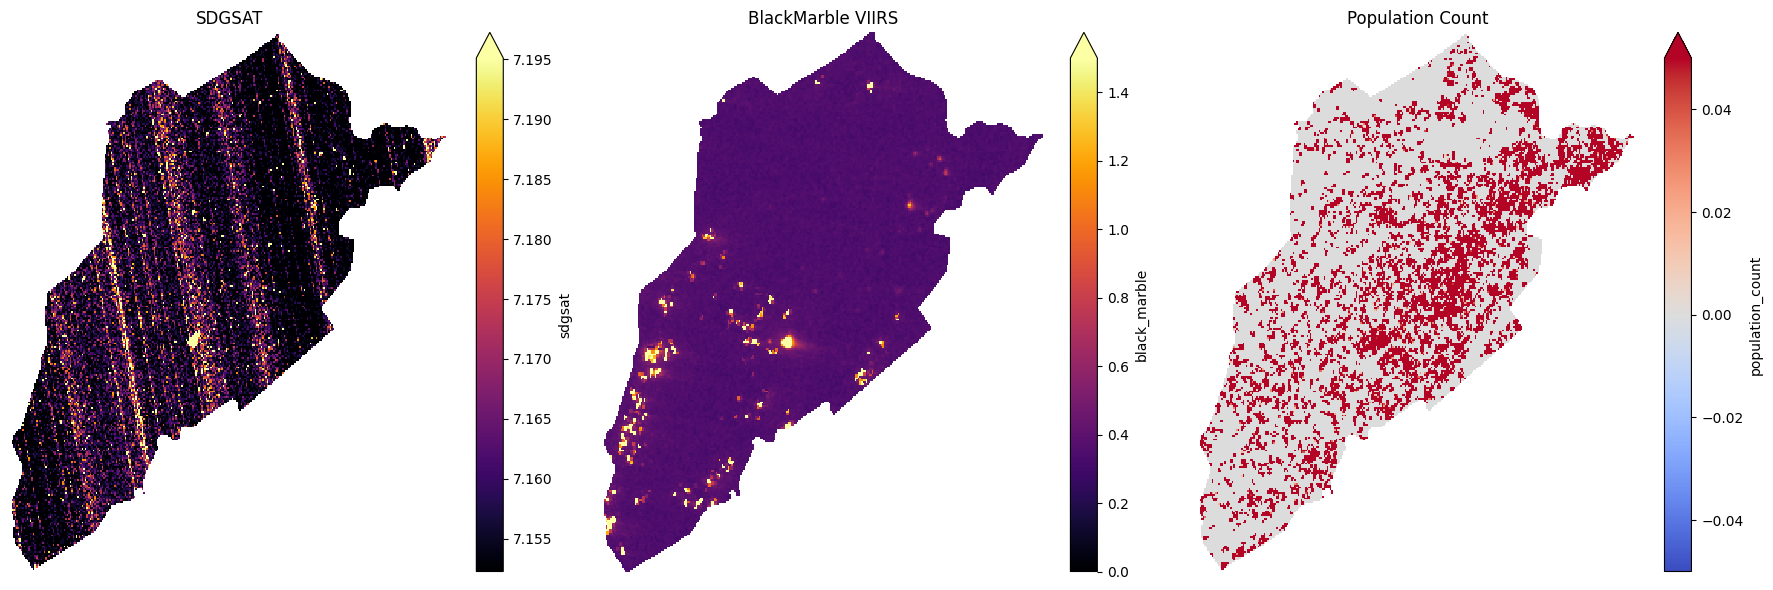

In [8]:
xds = get_rasters_for_admin("Bandiagara", date)
plot_layer_comparison(xds)

### Koro

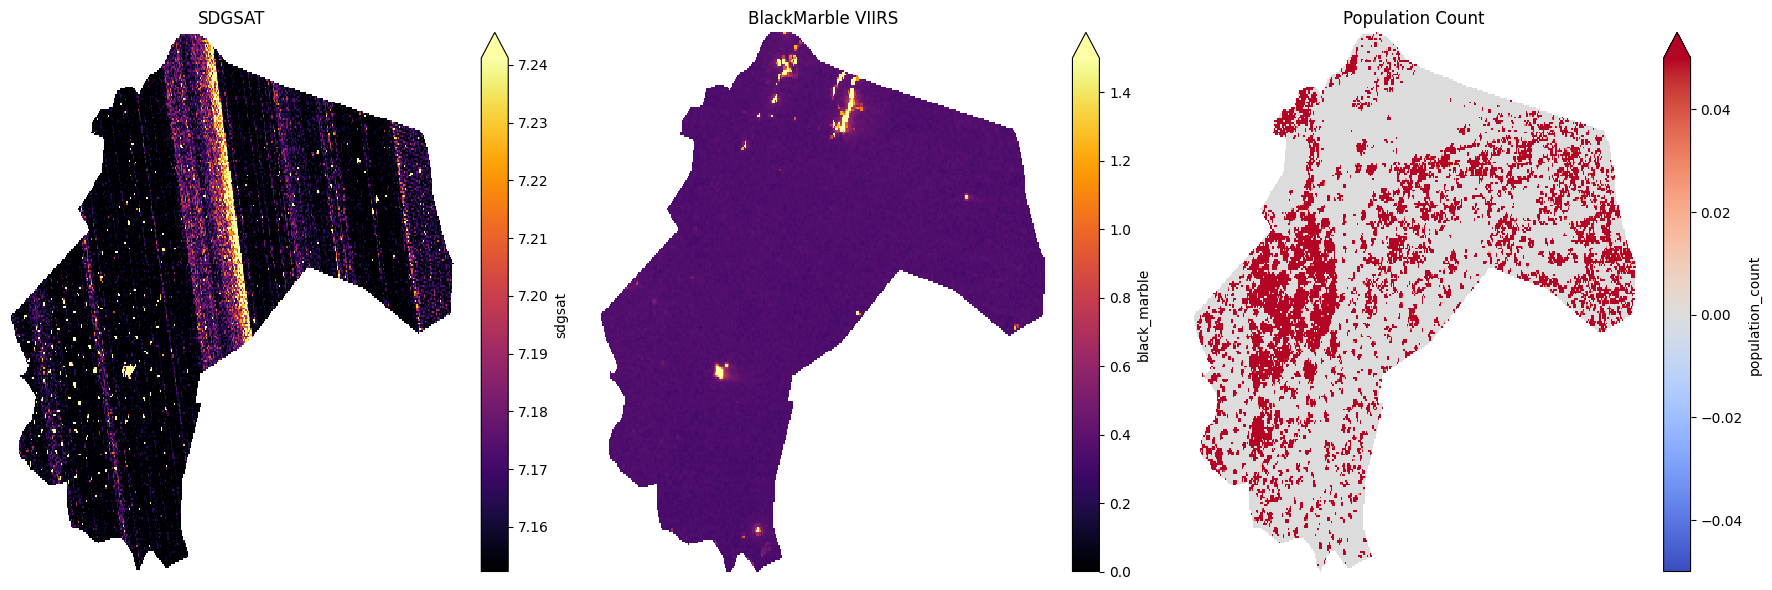

In [9]:
xds = get_rasters_for_admin("Koro", date)
plot_layer_comparison(xds)

## Central African Republic

In [10]:
date = datetime.date(2023, 2, 17)  # used for SDGSat tile

### Dékoa

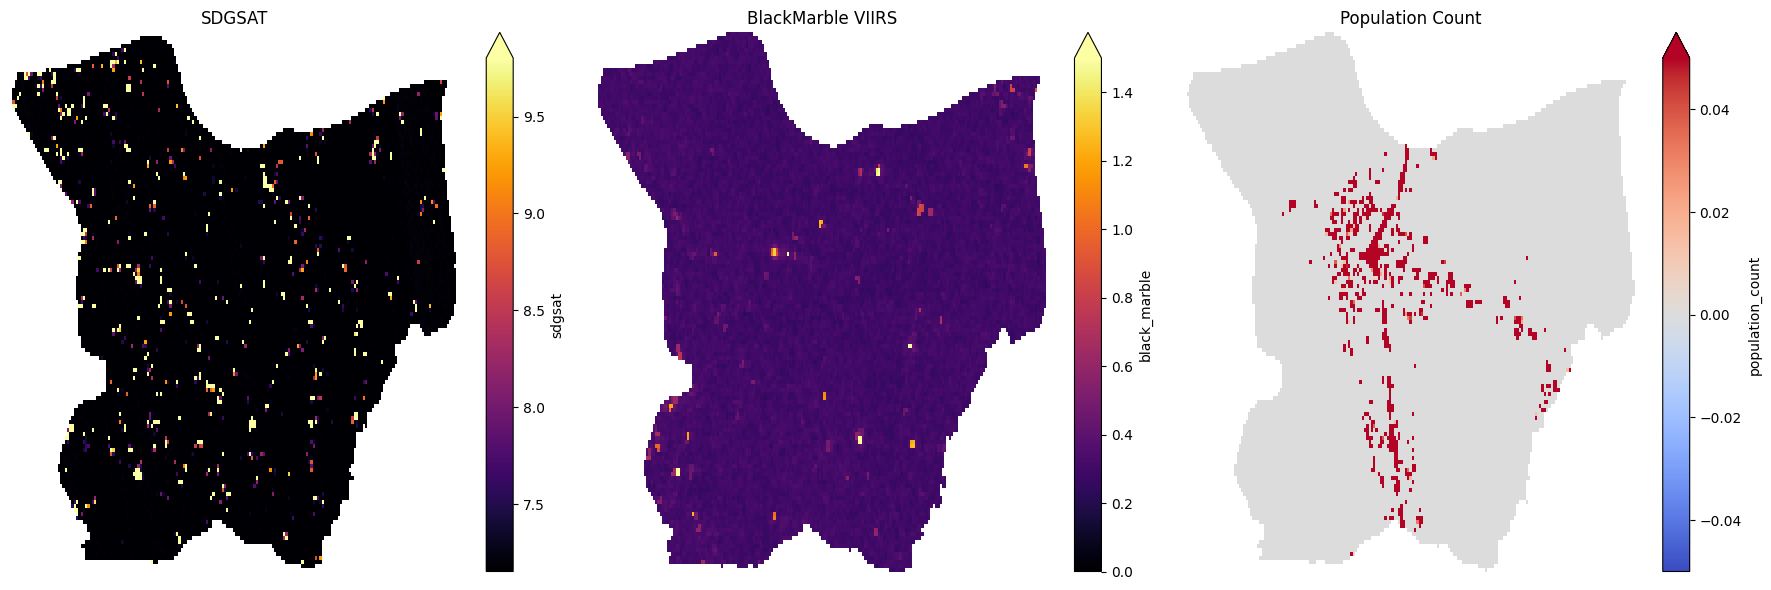

In [12]:
xds = get_rasters_for_admin("Dékoa", date)
plot_layer_comparison(xds)

### Mala

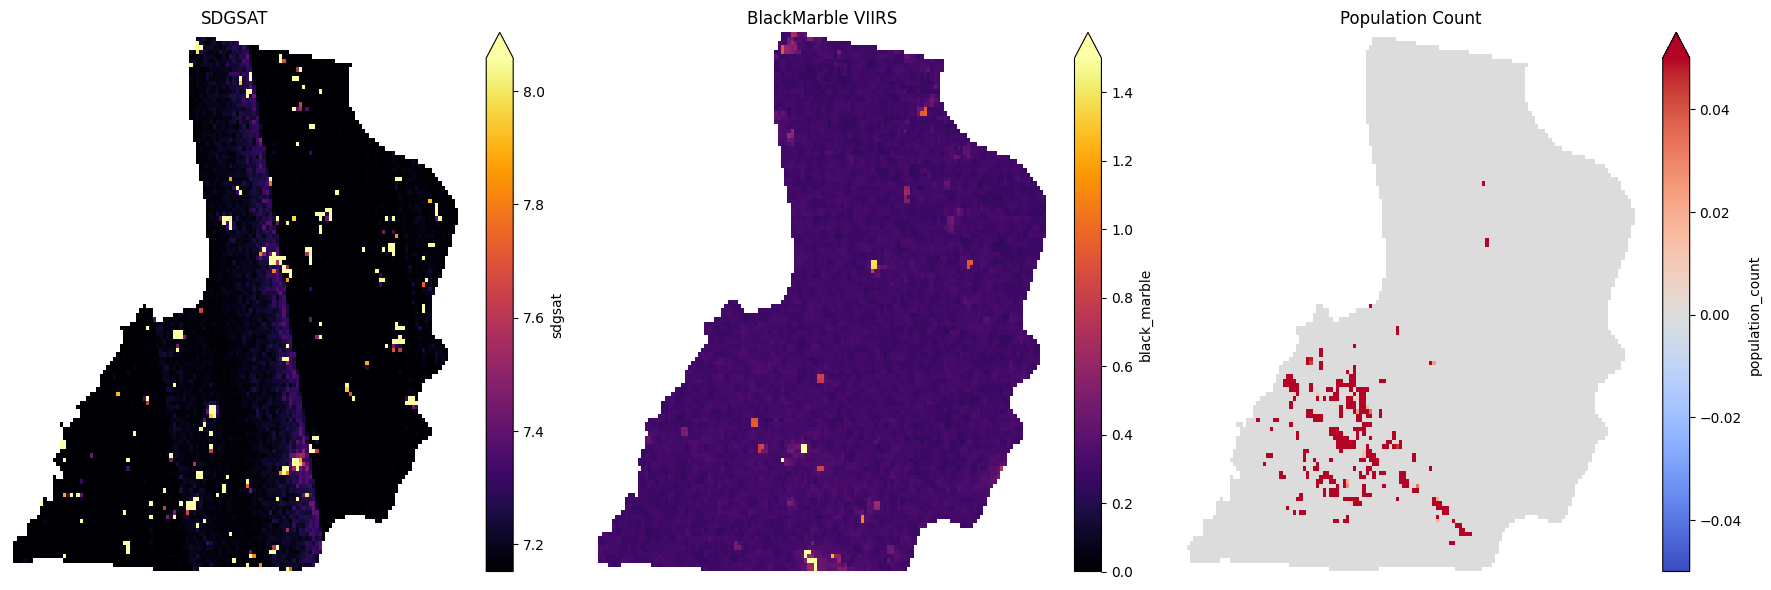

In [13]:
xds = get_rasters_for_admin("Mala", date)
plot_layer_comparison(xds)

### Mbrès

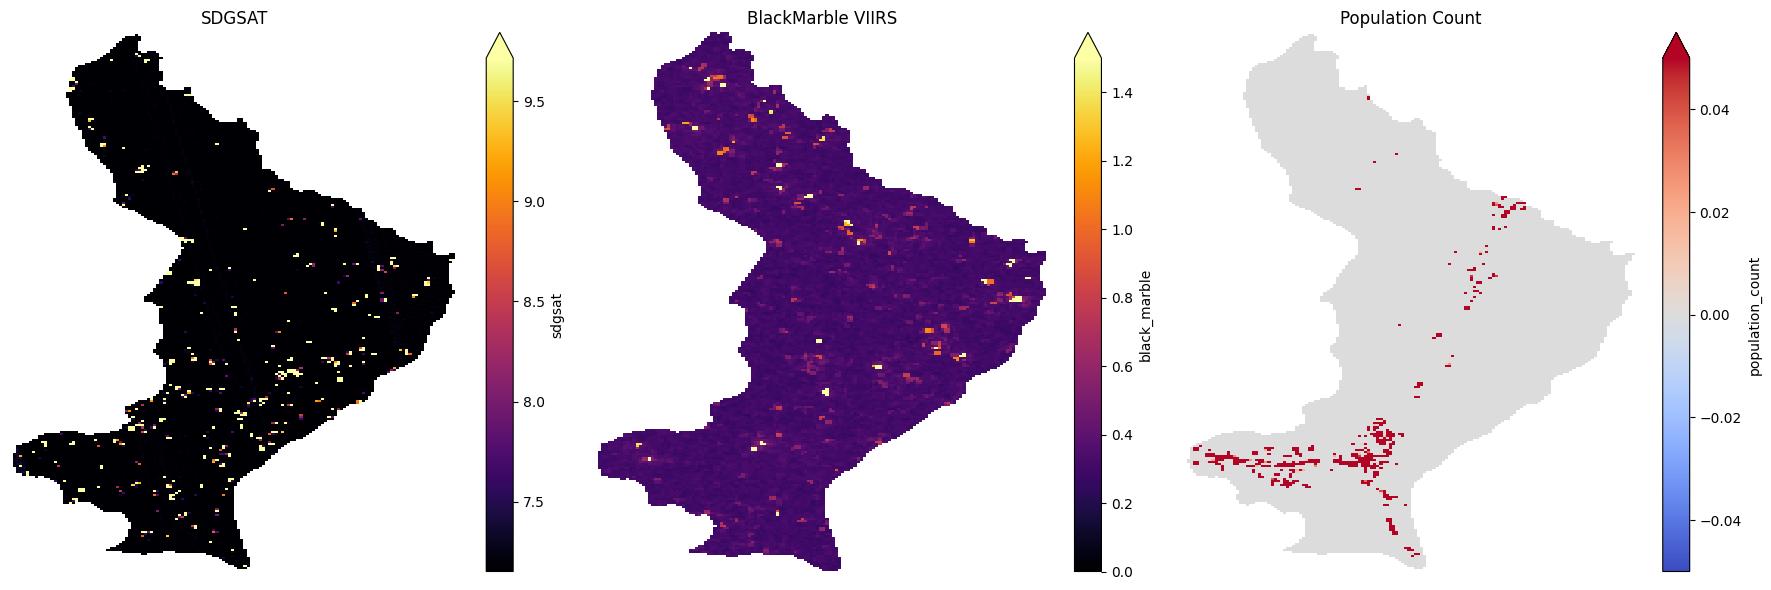

In [14]:
xds = get_rasters_for_admin("Mbrès", date)
plot_layer_comparison(xds)

### Kaga-Bandoro

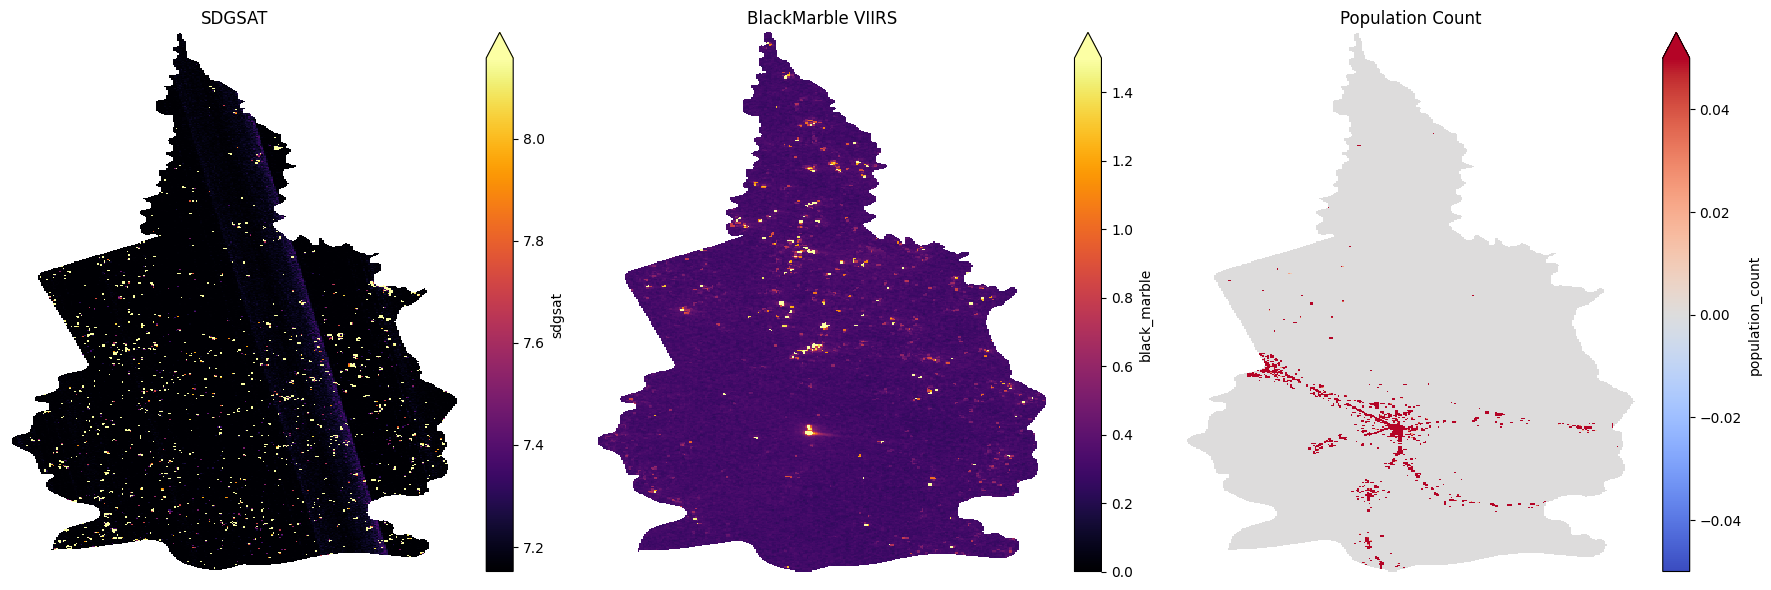

In [15]:
xds = get_rasters_for_admin("Kaga-Bandoro", date)
plot_layer_comparison(xds)